In [1]:
#!pip install -r requirements.txt

In [2]:
#!pip install datasets

In [3]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Deep Average Network для определения сентимента 

In [4]:
#!wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
#!gzip -d cc.en.300.vec.gz

In [5]:
def load_embeddings(path, pad_token='<PAD>', unk_token='<UNK>', num_tokens=100_000, verbose=True):
    

    with open(path) as f:

        vocab_size, embedding_dim = f.readline().strip().split()

        vocab_size = int(vocab_size)
        embedding_dim = int(embedding_dim)

        num_tokens = vocab_size if num_tokens <= 0 else num_tokens
        token2index: Dict[str, int] = dict()
        token2index[pad_token] = 0
        token2index[unk_token] = 1

        embeddings_matrix: np.array = np.zeros((num_tokens, embedding_dim))
        embeddings_matrix[1,:] = np.ones(embedding_dim)

        progress_bar = tqdm(total=num_tokens, disable=not verbose, desc='Reading embeddings file')

        for line in f:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token in token2index:
                continue
            token_id = len(token2index)
            token2index[token] = token_id

            embeddings_matrix[token_id, :] = np.array(list(map(float, parts[-embedding_dim:])))

            progress_bar.update()

            if len(token2index) == num_tokens:
                break

        progress_bar.close()

    assert(len(token2index) == embeddings_matrix.shape[0])
    
    return token2index, embeddings_matrix

In [6]:
token2index, embeddings_matrix = load_embeddings('/content/cc.en.300.vec', num_tokens=100_000)

Reading embeddings file: 100%|█████████▉| 99998/100000 [00:16<00:00, 6039.64it/s]


In [ ]:
token2index

In [ ]:
embeddings_matrix

In [9]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


In [10]:
def empty_collate(batch):
    return batch

In [11]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=empty_collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, collate_fn=empty_collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=empty_collate)

In [12]:
lengths = [len(sample[0]['text']) for sample in tqdm(train_loader)]

100%|██████████| 357/357 [00:05<00:00, 71.10it/s]


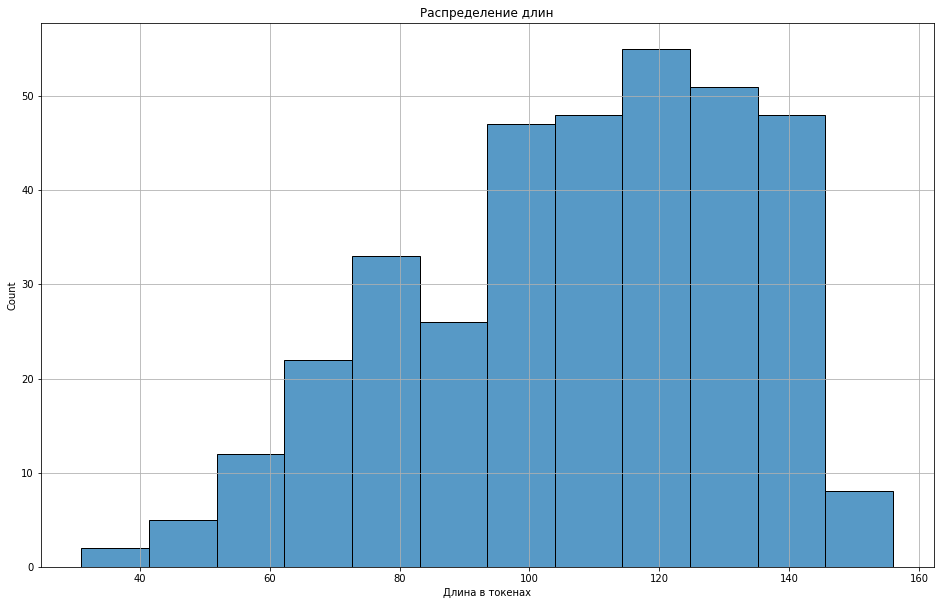

In [13]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.title("Распределение длин")
plt.xlabel("Длина в токенах")
sns.histplot(lengths)

In [14]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer  
        
        self.token2index = token2index  
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        indxs  = [self.token2index.get(text, self.unk_index) for text in tokenized_text] 
        
        return indxs 
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        while len(tokens_indices)< self.max_length:
          tokens_indices.append(self.pad_index)
        
        if len(tokens_indices)> self.max_length:
          tokens_indices = tokens_indices[:self.max_length]
          
        return tokens_indices
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        tokenized_text = self.tokenize(text)
        tokens_indices = self.indexing(tokenized_text)
        return self.padding(tokens_indices)
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            label = sample["label"]
            text = sample["text"]
            tokenized_texts.append(self(text))
            labels.append(label)
            
        tokenized_texts = torch.tensor(tokenized_texts)
        labels = torch.tensor(labels)
        
        return tokenized_texts, labels

In [15]:
tokenizer = Tokenizer(
    base_tokenizer=ToktokTokenizer(),
    token2index=token2index,
    pad_token='<PAD>',
    unk_token='<UNK>',
    max_length= 64
)

## <Место для реализации>

In [16]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)

In [17]:
for x, y in train_loader:
    break

In [18]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Я выбрала метрику 'weighted-f1'
Почему я выбрал эту метрику:  

Данная метрика лучше всего подходит для мультиклассовой классификации. Так как у меня нет уверенности в сбалансированности классов, был выбран именно 'weighted' вариант, а не 'macro'. 

In [19]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self,
                 n_embed: int,
                 d_embed: int,
                 d_hidden: int,
                 d_out: int,
                 dp: float,
                 embed_weight:np.array):
        super(DeepAverageNetwork, self).__init__()


        self.embed = nn.Embedding(n_embed, d_embed)

 
        self.dropout1 = nn.Dropout(dp)
        self.bn1 = nn.BatchNorm1d(d_embed)
        self.fc1 = nn.Linear(d_embed, d_hidden)
        self.non_linear_function = torch.nn.ReLU()
        self.dropout2 = nn.Dropout(dp)
        self.bn2 = nn.BatchNorm1d(d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_out)

    def forward(self, x):

        x = self.embed(x)

        x = x.mean(dim=1)

        x = self.dropout1(x)
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.non_linear_function(x)
        x = self.dropout2(x)
        x = self.bn2(x)
        x = self.fc2(x)

        return x

In [20]:
model = DeepAverageNetwork(n_embed=100_000, d_embed=len(embeddings_matrix[0]),d_hidden=128, d_out=3, dp=0.25, embed_weight= embeddings_matrix)

In [21]:
model

DeepAverageNetwork(
  (embed): Embedding(100000, 300)
  (dropout1): Dropout(p=0.25, inplace=False)
  (bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (non_linear_function): ReLU()
  (dropout2): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [22]:
from sklearn.metrics import f1_score


def train(model, iterator, optimizer, criterion):
    
    losses = list()
    f1 = list()
    
    model.train()  

    for x, y in tqdm(iterator, total=len(iterator)):
        
        optimizer.zero_grad()   
        predictions = model(x.to(device)).squeeze() 
        loss = criterion(predictions, y.to(device))        
               
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().cpu().numpy().argmax(1).tolist()
        y_true = y.tolist()
        
        losses.append(loss.item())
        f1.append(f1_score(y_true, preds, average="weighted"))
        
    return np.mean(f1), np.mean(losses)


def evaluate(model, iterator, criterion):
    
    losses = list()
    f1 = list()
    
    model.eval()  
    with torch.no_grad():
        for x, y in tqdm(iterator, total=len(iterator)):   

            predictions = model(x.to(device)).squeeze()  
            loss = criterion(predictions, y.to(device))        
            preds = predictions.detach().cpu().numpy().argmax(1).tolist()
            y_true = y.tolist()
            

            losses.append(loss.item())  
            f1.append(f1_score(y_true, preds, average="weighted"))
            
    return np.mean(f1), np.mean(losses) 

## Задайте функцию потерь и оптимизатор

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

## Сделайте цикл обучения

In [24]:
# Задайте количество эпох
NUM_EPOCHS = 10

losses = list()
loss_on_eval = list()

f1 = list()
f1_on_eval = list()

for n_epoch in range(NUM_EPOCHS):
    print(n_epoch)
    f1_train, loss_train = train(model=model, iterator=train_loader, optimizer=optimizer, criterion=criterion)
    f1.append(f1_train)
    losses.append(loss_train)
    f1_valid, loss_valid = evaluate(model=model, iterator=valid_loader, criterion=criterion)
    f1_on_eval.append(f1_valid)
    loss_on_eval.append(loss_valid)


    print('Loss_on_train:{lt}, F1_train:{ft},\nLoss_on_valid:{lv}, F1_valid: {fv}'.format(lt = loss_train, ft = f1_train, lv = loss_valid, fv = f1_valid))
    print('---')


0


100%|██████████| 16/16 [00:00<00:00, 38.62it/s]


Loss_on_train:1.1211505280155427, F1_train:0.403844427127986,
Loss_on_valid:1.0634995326399803, F1_valid: 0.3849500956594555
---
1


100%|██████████| 16/16 [00:00<00:00, 35.59it/s]


Loss_on_train:1.0556189935414397, F1_train:0.44607359024797505,
Loss_on_valid:1.0283311493694782, F1_valid: 0.40305722068834937
---
2


100%|██████████| 16/16 [00:00<00:00, 39.69it/s]


Loss_on_train:1.0220153979560573, F1_train:0.4619677824946012,
Loss_on_valid:1.0042855963110924, F1_valid: 0.4255792358716018
---
3


100%|██████████| 16/16 [00:00<00:00, 37.13it/s]


Loss_on_train:1.001427329721905, F1_train:0.47059972299016134,
Loss_on_valid:0.9883677624166012, F1_valid: 0.4249103023737897
---
4


100%|██████████| 16/16 [00:00<00:00, 38.93it/s]


Loss_on_train:0.9885007056201539, F1_train:0.47518028827641623,
Loss_on_valid:0.977292850613594, F1_valid: 0.43766692020383896
---
5


100%|██████████| 16/16 [00:00<00:00, 41.89it/s]


Loss_on_train:0.9806646881651144, F1_train:0.4760891762223823,
Loss_on_valid:0.9695588499307632, F1_valid: 0.4533488978341758
---
6


100%|██████████| 16/16 [00:00<00:00, 39.83it/s]


Loss_on_train:0.974154908283084, F1_train:0.47811550989158125,
Loss_on_valid:0.9661760292947292, F1_valid: 0.4542610875872342
---
7


100%|██████████| 16/16 [00:00<00:00, 40.50it/s]


Loss_on_train:0.9698717208469615, F1_train:0.48354397151481887,
Loss_on_valid:0.9589758813381195, F1_valid: 0.4734972334401383
---
8


100%|██████████| 16/16 [00:00<00:00, 39.31it/s]


Loss_on_train:0.9627093806320212, F1_train:0.4928793269352088,
Loss_on_valid:0.9543654508888721, F1_valid: 0.47795869077709086
---
9


100%|██████████| 16/16 [00:00<00:00, 39.83it/s]

Loss_on_train:0.9569140056602093, F1_train:0.4960873287116233,
Loss_on_valid:0.9515315219759941, F1_valid: 0.4816471297760757
---


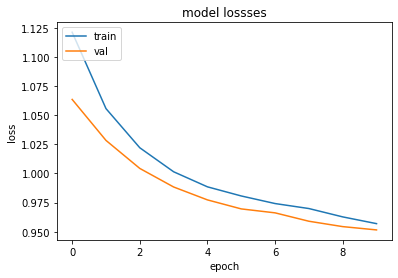

In [25]:
plt.plot(losses)
plt.plot(loss_on_eval)
plt.title('model lossses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

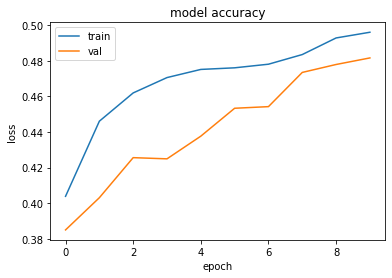

In [26]:
plt.plot(f1)
plt.plot(f1_on_eval)
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
def model_test(model, iterator, criterion):
    mod_preds = list()
    true = list()
    model.eval()  
    with torch.no_grad():
        for x, y in tqdm(iterator, total=len(iterator)):   

            predictions = model(x.to(device)).squeeze()         
            preds = predictions.detach().cpu().numpy().argmax(1).tolist()
            y_true = y.tolist()
            
            mod_preds.extend(preds)
            true.extend(y_true)
    return true, mod_preds

In [28]:
true, preds = model_test(model=model, iterator=test_loader, criterion=criterion)
assert len(true) == len(preds)

100%|██████████| 96/96 [00:02<00:00, 40.63it/s]


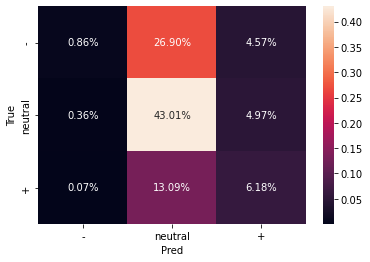

In [29]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true, preds)
ax = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%')

ax.set_xlabel('Pred')
ax.set_ylabel('True');

ax.xaxis.set_ticklabels(['-','neutral', '+'])
ax.yaxis.set_ticklabels(['-','neutral', '+'])

plt.show()

# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

Удалось обучить перцептрон, но результат получился скромный. Возможно, результат улучшился бы с увеличением количества эпох, но в таком случае потребовался бы early stopping для предотвращения овер фиттинга модели. 

Я считаю, что более качественная предобработка данных также могла бы улучшить результат, так как на данном этапе получается большое количество UNKов, что негативно отражается на эмбеддингах. К увеличению качества модели могло бы привести и увеличение тренировочной выборки: в настоящий момент модель лучше всего справилась с классификацией нейтральных сентиментов. Это говорит о том, что данный класс лучше всего представлен в тренировочных данных.